# Практика 11
## Задание 11.2

In [11]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression

import warnings
warnings.filterwarnings('ignore')

import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats

from sklearn.model_selection import train_test_split

from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from sklearn.ensemble import ExtraTreesRegressor

In [12]:
rent = pd.read_csv('../data/move.csv')
rent.drop('Unnamed: 0', axis=1, inplace=True)
rent

metro  price   way  views  \
0                      Planernaia   45000  walk    513   
1                           VDNKh   50000  walk    389   
2                   Alekseevskaia   50000  walk    483   
3                        Sviblovo   38000  walk    414   
4                        Rimskaia   55999  walk    360   
...                            ...    ...   ...    ...   
1441                    Solntcevo   25000  walk    189   
1442    Ulitca Starokachalovskaia   25000  walk    173   
1443                    Zhulebino   25000  walk    102   
1444   Preobrazhenskaia ploshchad   40000  walk     60   
1445                  Rasskazovka   30000  walk   2728   

                         provider  fee_percent  storey  minutes  storeys  \
0     realtor                               50       7       10       12   
1     realtor                               50      16       10       16   
2     realtor                               50       5        3       12   
3     realtor                               50       3       15        5   
4     realtor                               99       6        7       17   
...                           ...          ...     ...      ...      ...   
1441     realtor                             0       6        5       23   
1442     realtor                             0       5        5       17   
1443     realtor                             0       5        5       12   
1444     realtor                            30       3       17        9   
1445       owner                             0      12       10       17   

      living_area  kitchen_area  total_area  
0              19             8          38  
1              18             8          41  
2              19             5          33  
3              37            37          37  
4              21            10          40  
...           ...           ...         ...  
1441           20            10          36  
1442           20            10          38  
1443           20            10          35  
1444           20             8          35  
1445           22             8          33  

[1446 rows x 12 columns]

In [13]:
rent.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1446 entries, 0 to 1445
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   metro         1446 non-null   object
 1   price         1446 non-null   int64 
 2   way           1446 non-null   object
 3   views         1446 non-null   int64 
 4   provider      1446 non-null   object
 5   fee_percent   1446 non-null   int64 
 6   storey        1446 non-null   int64 
 7   minutes       1446 non-null   int64 
 8   storeys       1446 non-null   int64 
 9   living_area   1446 non-null   int64 
 10  kitchen_area  1446 non-null   int64 
 11  total_area    1446 non-null   int64 
dtypes: int64(9), object(3)
memory usage: 135.7+ KB


Обработка дубликатов

In [14]:
dupl = len(rent)- len(rent.drop_duplicates())
print('Количество дубликатов в выборке: ', dupl)

Количество дубликатов в выборке:  1201


In [15]:
# удаление дубликатов из выборки
rent.drop_duplicates(inplace=True)
rent.reset_index(inplace=True, drop=True)

### Одномерный анализ

Анализ признака metro

In [16]:
rent['metro'].unique()

array([' Planernaia ', ' VDNKh ', ' Alekseevskaia ', ' Sviblovo ',
       ' Rimskaia ', ' Perovo ', ' Nekrasovka ', ' Riazanskii prospekt ',
       ' Medvedkovo ', ' Khovrino ', ' Okskaia ', ' Vystavochnaia ',
       ' Otradnoe ', ' Kuntcevskaia ', ' Shabolovskaia ',
       ' Dobryninskaia ', ' Paveletckaia ', ' Altufevo ', ' Tcaritcyno ',
       ' Shchelkovskaia ', ' Skhodnenskaia ', ' Solntcevo ',
       ' Ulitca Starokachalovskaia ', ' Zhulebino ',
       ' Preobrazhenskaia ploshchad ', ' Rasskazovka ',
       ' Buninskaia Alleia ', ' Fili ', ' Kommunarka ',
       ' Cherkizovskaia ', ' Lukhmanovskaia ', ' Teplyi Stan ',
       ' Prazhskaia ', ' Mezhdunarodnaia ', 'No data', ' Filatov Lug ',
       ' Annino ', ' Beliaevo ', ' Liublino ', ' Kuzminki ',
       ' Novye Cheremushki ', ' Marino ', ' Strogino ', ' Salarevo ',
       ' Piatnitckoe shosse ', ' Izmailovskaia ',
       ' Petrovsko-Razumovskaia ', ' Tekstilshchiki ', ' Novokosino ',
       ' Ulitca Dmitrievskogo ', ' Nagornaia

Можно убрать пробелы из наименований метро и посмотреть число квартир без указания метро.

In [17]:
# убираем пробелы из наименований
rent['metro'] = rent['metro'].apply(lambda x: x.strip())

In [18]:
# число квартир без указания метро
len(rent[rent['metro']=='No data'])

36

Возможно это квартиры, расположенные далеко от метро (в области). <br>
В дальнейшем их можно отделить в отдельную категорию (кластер).

Анализ признака way

In [19]:
rent['way'].unique()

array(['walk', 'transport'], dtype=object)

Для модели: dummy переменные по признаку way (1 фиктивная переменная)

Анализ признака provider

In [20]:
# удаление пробельных символов
rent['provider'] = rent['provider'].apply(lambda x: x.strip())

In [21]:
# просмотр уникальных значений
rent['provider'].unique()

array(['realtor', 'owner', 'agency', 'Застройщик'], dtype=object)

In [22]:
# переименование значений на англ
rent['provider'].replace('Застройщик', 'builder', inplace=True)

Для модели: dummy переменные по признаку provider (3 фиктивных переменных)

Анализ признака fee_percent	<br>
Он должен быть в пределах 0 - 100

In [23]:
set(rent['fee_percent'] < 0)

{False}

In [24]:
set(rent['fee_percent'] > 100)

{False}

Анализ признаков storey и storeys <br>
Признак storey должен быть меньше или равен storeys

In [25]:
set(rent.storey <= rent.storeys)

{True}

Анализ признаков kitchen_area, living_area и total_area <br>

In [26]:
# есть ли квартиры общей площадью больше, чем суммарная площадь кухни и жилого помещения
set((rent.kitchen_area > rent.total_area)|(rent.living_area > rent.total_area))

{False, True}

In [27]:
rent[(rent.kitchen_area > rent.total_area)|(rent.living_area > rent.total_area)]

metro   price        way  views provider  fee_percent  \
33           Kommunarka   40000       walk     65    owner           50   
94   Krasnogvardeiskaia   34000       walk     16   agency           60   
115  Piatnitckoe shosse   30000  transport     96    owner            0   
142           Vladykino   44000       walk     17   agency           50   
143   Buninskaia Alleia   29200  transport     20   agency           50   
144          Shelepikha   59000       walk     21   agency            0   
147             No data   31200       walk      5   agency           50   
148       Aviamotornaia   62100       walk     17   agency           50   
149            Govorovo   57000       walk     26   agency           50   
151            Salarevo   57000       walk     28   agency           50   
154              Annino   57000       walk     49   agency           50   
168    Ulitca 1905 goda  135000       walk     14   agency           25   
179        Belorusskaia  135000       walk     12   agency            0   
229            Salarevo   60000       walk     37   agency           50   

     storey  minutes  storeys  living_area  kitchen_area  total_area  
33        4       10       15           15             5           5  
94        8        8        9            6            18           6  
115       3       47       14           21             9           3  
142       4        7        5           10             4           8  
143       5       21       16           10             4           4  
144       2        6       12           19             7           8  
147       5        0        7           15             7           5  
148      15        5       23           11            10           4  
149      10        6       23           25            10           5  
151      23       19       24           15            16           7  
154      24        8       25           14             4           1  
168       8       12       44           26             7           8  
179       6       14        9           25             5           5  
229      15       19       25           12            11           4

Общая площадь не может быть меньше жилой площади и/или площади кухни. <br>
Такую ошибку в данных можно исправить, заменив некорректные значения total_area на сумму living_area и kitchen_area.

In [28]:
rent['total_area'] = np.where((rent.kitchen_area > rent.total_area)|(rent.living_area > rent.total_area), 
                            rent.kitchen_area + rent.living_area, 
                            rent.total_area)

#### Обработка выбросов

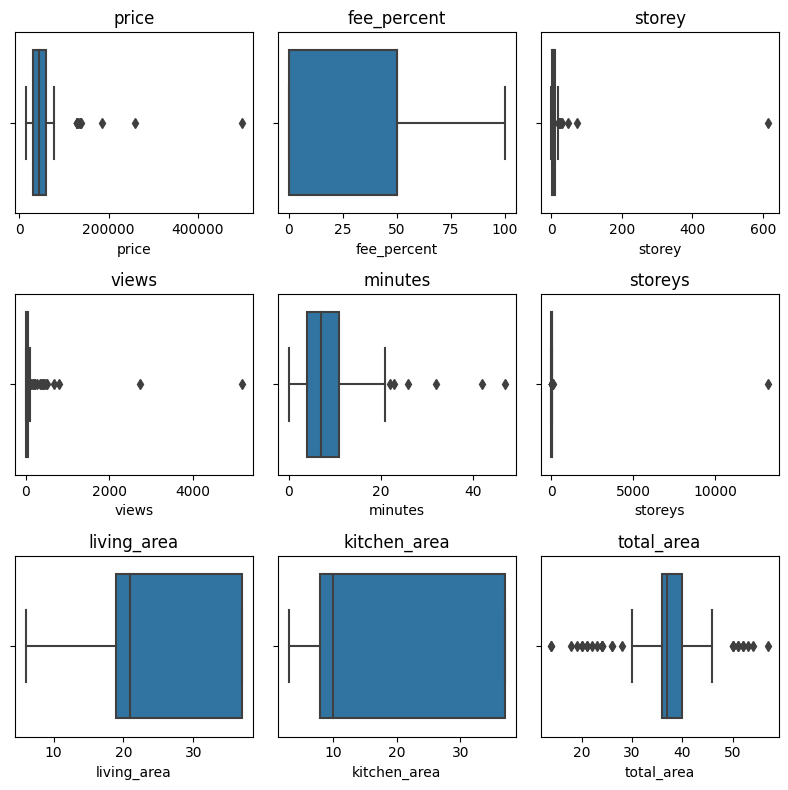

In [29]:
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(8, 8))

outliers = ['price', 'fee_percent', 'storey', 'views', 
            'minutes', 'storeys',
           'living_area', 'kitchen_area', 'total_area']

i = 0

for x in range(3):
    for y in range(3):
    
        sns.boxplot(data = rent,
                    x = outliers[i],
                   ax = axes[x, y])

        axes[x, y].set_title(outliers[i])

        i += 1
        
fig.tight_layout()
plt.show()

In [30]:
# продолжительность пути до центра более получаса 
mins_outlier = rent[rent.minutes > 30]
mins_outlier

metro  price        way  views provider  fee_percent  \
71            Solntcevo  21000  transport     51    owner            0   
115  Piatnitckoe shosse  30000  transport     96    owner            0   
172              Mitino  30000  transport     68   agency           60   

     storey  minutes  storeys  living_area  kitchen_area  total_area  
71        5       32        9           30            12          42  
115       3       47       14           21             9          30  
172       6       42       12           19            12          38

In [31]:
# создание словаря со средней продолжительностью пути до каждого метро
df_mins = rent[rent.minutes < 30]
mins = [int(df_mins[df_mins.metro == i].minutes.mean()) for i in rent.metro.unique()]
dct = {key: value for key, value in zip(rent.metro.unique(), mins)}

In [32]:
# замена аномальных значений по признаку minutes на более адекватные
for metro in mins_outlier.metro:
    rent['minutes'] = np.where(rent['minutes'] > 30, dct[metro], rent.minutes)

In [33]:
# проверка признаков storey и storeys
rent[rent['storeys'] > 50]

metro   price   way  views provider  fee_percent  storey  \
39    Mezhdunarodnaia  260000  walk    110  realtor           50      74   
162  Bagrationovskaia   60000  walk     15   agency            0     613   

     minutes  storeys  living_area  kitchen_area  total_area  
39         0       95           31            20          51  
162       10    13217           18            10          40

In [34]:
rent.drop(rent[rent['storeys'] > 50].index, inplace=True)

Эти объекты можно удалить из выборки.

In [35]:
# проверка признака views
rent[rent['views'] > 500]

metro  price   way  views provider  fee_percent  storey  minutes  \
0    Planernaia  45000  walk    513  realtor           50       7       10   
5        Perovo  29000  walk   5174  realtor           40       2       15   
7    Planernaia  39000  walk    795  realtor           50       8       10   
8    Planernaia  35000  walk    687  realtor           50       6       15   
29  Rasskazovka  30000  walk   2728    owner            0      12       10   

    storeys  living_area  kitchen_area  total_area  
0        12           19             8          38  
5         5           17             7          31  
7         9           18             7          33  
8         9           17             6          34  
29       17           22             8          33

Заменю четырехзначные числа на трехзначные. Так более правдоподобно.

In [36]:
rent['views'].iloc[5] = 517
rent['views'].iloc[29] = 272

In [37]:
# проверка признака total_area
rent[rent['total_area'] < 15]

metro  price        way  views provider  fee_percent  storey  \
142          Vladykino  44000       walk     17   agency           50       4   
143  Buninskaia Alleia  29200  transport     20   agency           50       5   

     minutes  storeys  living_area  kitchen_area  total_area  
142        7        5           10             4          14  
143       21       16           10             4          14

Квартиры площадью 14 кв.м не будет считать выбросом.

Чтобы не испортить качество модели, лучше удалить выбросы по признакам storey, storeys и price.

In [38]:
# удаление выбросов
rent = rent[(np.abs(stats.zscore(rent[['storey', 'storeys', 'price', 'views', 'total_area', 'minutes']])) < 3).all(axis=1)]

In [39]:
# сохранение индексации
rent.reset_index(inplace=True, drop=True)

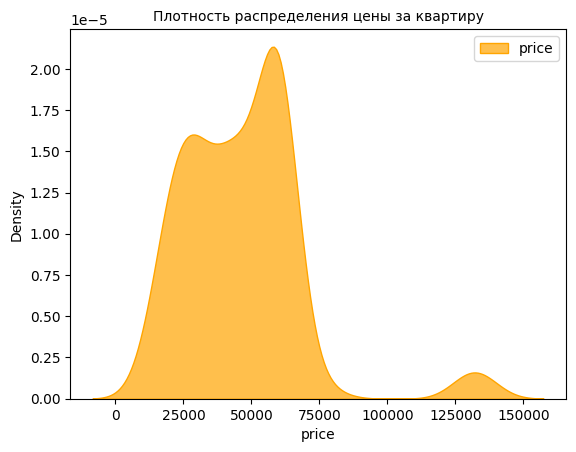

In [40]:
# анализ признака price
# Посмотрим на распределение цены
sns.kdeplot(data=rent, 
            x='price', 
            shade=True, 
            color="orange", 
            label="price", 
            alpha=.7, 
            common_norm = True)

plt.title('Плотность распределения цены за квартиру', fontsize=10)
plt.legend()
plt.show()

В среднем стоимость квартиры колеблется от 25 000 до 75 000 у.е. <br>
Есть и более дорогие квартиры в выборке, чья стоимость находится в пределах от 120 000 до 150 000.

#### Разделение выборки на обучающую и тестовую

In [41]:
# выделение зависимой и независимых переменных
y = rent['price']
x = rent.drop('price', axis=1)

In [42]:
# разбиение выборки на обучающую и тестовую
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42, shuffle=False)

#### Кодирование категориальных переменных

In [43]:
import category_encoders as ce

# кодирование категориальных переменных
encoder = ce.CountEncoder()
x_train = encoder.fit_transform(x_train)
x_test = encoder.transform(x_test)

#### Построение моделей регрессии

RandomForestRegressor

In [44]:
rfr = RandomForestRegressor(max_depth=2)

# обучение модели
rfr.fit(x_train, y_train)

# Прогнозирование цены на тестовой выборке
rfr_pred = rfr.predict(x_test)

XGBRegressor

In [45]:
xgb_r = xgb.XGBRegressor()

# обучение модели
xgb_r.fit(x_train, y_train)

# Прогнозирование цены на тестовой выборке
xgb_pred = xgb_r.predict(x_test)

ExtraTreesRegressor

In [46]:
etr = ExtraTreesRegressor()

# обучение модели
etr.fit(x_train, y_train)

# Прогнозирование цены на тестовой выборке
etr_pred = etr.predict(x_test)

#### Оценка качества моделей

In [47]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import mean_squared_log_error

def r2(y_true, y_pred):
    r2 = r2_score(y_true, y_pred)
    return round(r2, 3)
    
def mae(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    return round(mae, 3)    

def mape(y_true, y_pred):
    mape = mean_absolute_percentage_error(y_true, y_pred)
    return round(mape, 3) 
    
def rmsle(y_true, y_pred):
    if any(x < 0 for x in y_pred):
        y_pred = [abs(i) for i in y_pred]
    rmsle = mean_squared_log_error(y_true, y_pred, squared=False)
    return round(rmsle, 3)

In [48]:
# count encoding
metrics = pd.DataFrame({'RandomForest': [r2(y_test, rfr_pred), mae(y_test, rfr_pred), mape(y_test, rfr_pred), rmsle(y_test, rfr_pred)],
                       'XGBoost': [r2(y_test, xgb_pred), mae(y_test, xgb_pred), mape(y_test, xgb_pred), rmsle(y_test, xgb_pred)],
                       'ExtraTree': [r2(y_test, etr_pred), mae(y_test, etr_pred), mape(y_test, etr_pred), rmsle(y_test, etr_pred)]},
                      index=['R2', 'MAE', 'MAPE','RMSLE'])
metrics

RandomForest    XGBoost  ExtraTree
R2           -0.219     -0.118      0.312
MAE       13320.461  13317.338  10824.618
MAPE          0.277      0.279      0.211
RMSLE         0.346      0.326      0.268

Модель ExtraTree лучше по всем рассчитанным метрикам.

#### Важность признаков

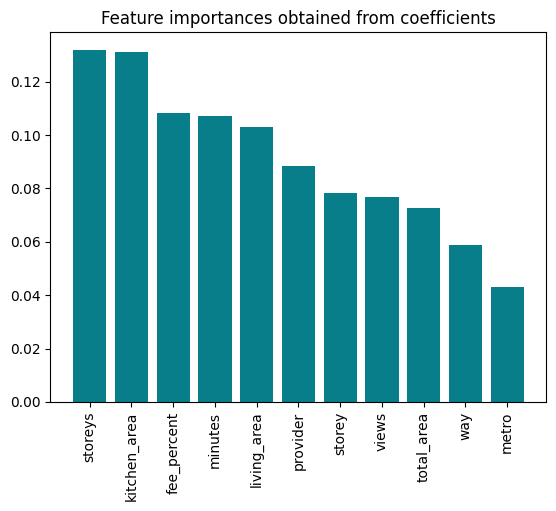

In [49]:
importances = pd.DataFrame(data={
    'Attribute': x_train.columns,
    'Importance': etr.feature_importances_})

importances = importances.sort_values(by='Importance', ascending=False)

plt.bar(x=importances['Attribute'], height=importances['Importance'], color='#087E8B')
plt.title('Feature importances obtained from coefficients', size=12)
plt.xticks(rotation='vertical')
plt.show()

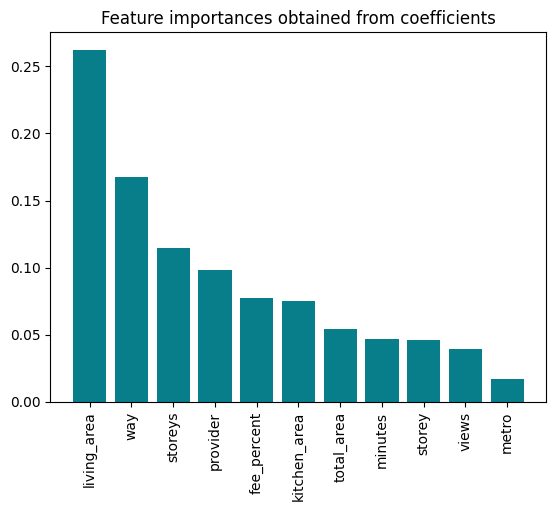

In [50]:
importances = pd.DataFrame(data={
    'Attribute': x_train.columns,
    'Importance': xgb_r.feature_importances_})

importances = importances.sort_values(by='Importance', ascending=False)

plt.bar(x=importances['Attribute'], height=importances['Importance'], color='#087E8B')
plt.title('Feature importances obtained from coefficients', size=12)
plt.xticks(rotation='vertical')
plt.show()

Модель XGBoost описывает ситуацию более правдоподобно.

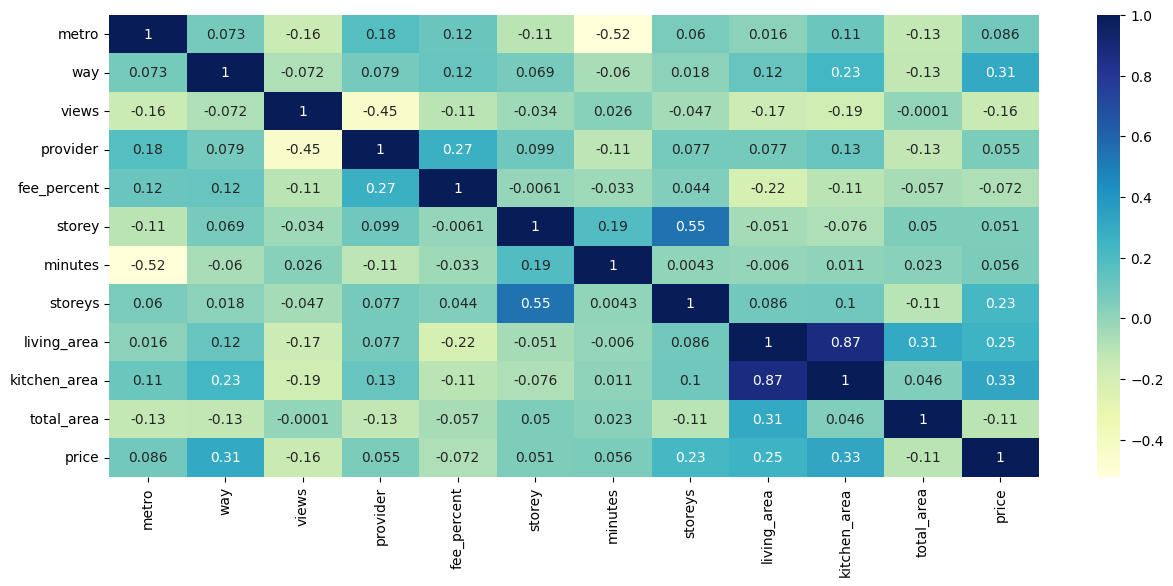

In [51]:
plt.figure(figsize=(15,6))
sns.heatmap(pd.concat([x_train, y_train], axis=1).corr(method='pearson'),annot=True,cmap="YlGnBu")
plt.show()

Вывод: <br>
Согласно построенной модели наиболее важным (решающим) признаком в образовании цены на квартиру является её жилая площадь. <br>
Также на цену квартиры достаточно сильно влияет количество этажей в доме и степень удаленности от метро.